# Predictive Modeling for Breast Cancer Survival Using METABRIC Clinical and Genomic Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from itertools import cycle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1
from sklearn.preprocessing import label_binarize


In [2]:
print("numpy version is:", np.__version__)
print("pandas version is:", pd.__version__)
print("matplotlib version is:", matplotlib.__version__)
print("seaborn version is:", sns.__version__)
print("Scikit-learn version is:", sklearn.__version__)
print("xGBoost version is:", xgb.__version__)
print("TensorFlow version is:", tf.__version__)

numpy version is: 1.24.3
pandas version is: 2.0.3
matplotlib version is: 3.7.2
seaborn version is: 0.12.2
Scikit-learn version is: 1.3.0
xGBoost version is: 2.1.0
TensorFlow version is: 2.16.1


In [3]:
breast_data = pd.read_csv("https://raw.githubusercontent.com/HDaaboul/Predictive-Modeling-for-Breast-Cancer-Survival/main/data/METABRIC_data.csv", index_col="patient_id", low_memory=False)
breast_data.head()

,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
patient_id,,,,,,,,,,,,,,,,,,,,,
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0


In [4]:
breast_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1904 entries, 0 to 7299
Columns: 692 entries, age_at_diagnosis to siah1_mut
dtypes: float64(496), int64(6), object(190)
memory usage: 10.1+ MB


## Data cleaning
### drop unuseful cols

In [5]:
to_drop_cols = ['cancer_type', 'oncotree_code']
breast_data.drop(columns=to_drop_cols, inplace=True)

### drop unuseful rows

In [6]:
to_drop_index = breast_data[breast_data.tumor_other_histologic_subtype == 'Metaplastic'].index
breast_data.drop(index=to_drop_index, inplace=True)

In [7]:
with open("all_columns_names.txt", "w") as file:
    i = 0
    for col in breast_data.columns:
        file.write("{0} {1}\n".format(i, col))
        i+=1

1. Clinical features
2. gene expression profile
3. RNA mutations

## organization of clinical cols

In [8]:
clinical_cols = breast_data.iloc[:, 0:27]
clinical_cols.head(1)

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage
patient_id,,,,,,,,,,,,,,,,,,,,,
0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1,Positve,Positive,3.0,...,10,NaN,6.044,140.5,1,Negative,1,ER-/HER2-,22.0,2.0


In [9]:
cli_cols_names = clinical_cols.columns
cli_cols_names

Index(['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type_detailed',
       'cellularity', 'chemotherapy', 'pam50_+_claudin-low_subtype', 'cohort',
       'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage'],
      dtype='object')

In [10]:
cli_cols_cat = clinical_cols.select_dtypes(include=object)
cli_cols_num = clinical_cols.select_dtypes(include=[np.number])

In [11]:
cli_cols_num_names = cli_cols_num.columns

In [12]:
cli_cols_num_names

Index(['age_at_diagnosis', 'chemotherapy', 'cohort',
       'neoplasm_histologic_grade', 'hormone_therapy',
       'lymph_nodes_examined_positive', 'mutation_count',
       'nottingham_prognostic_index', 'overall_survival_months',
       'overall_survival', 'radio_therapy', 'tumor_size', 'tumor_stage'],
      dtype='object')

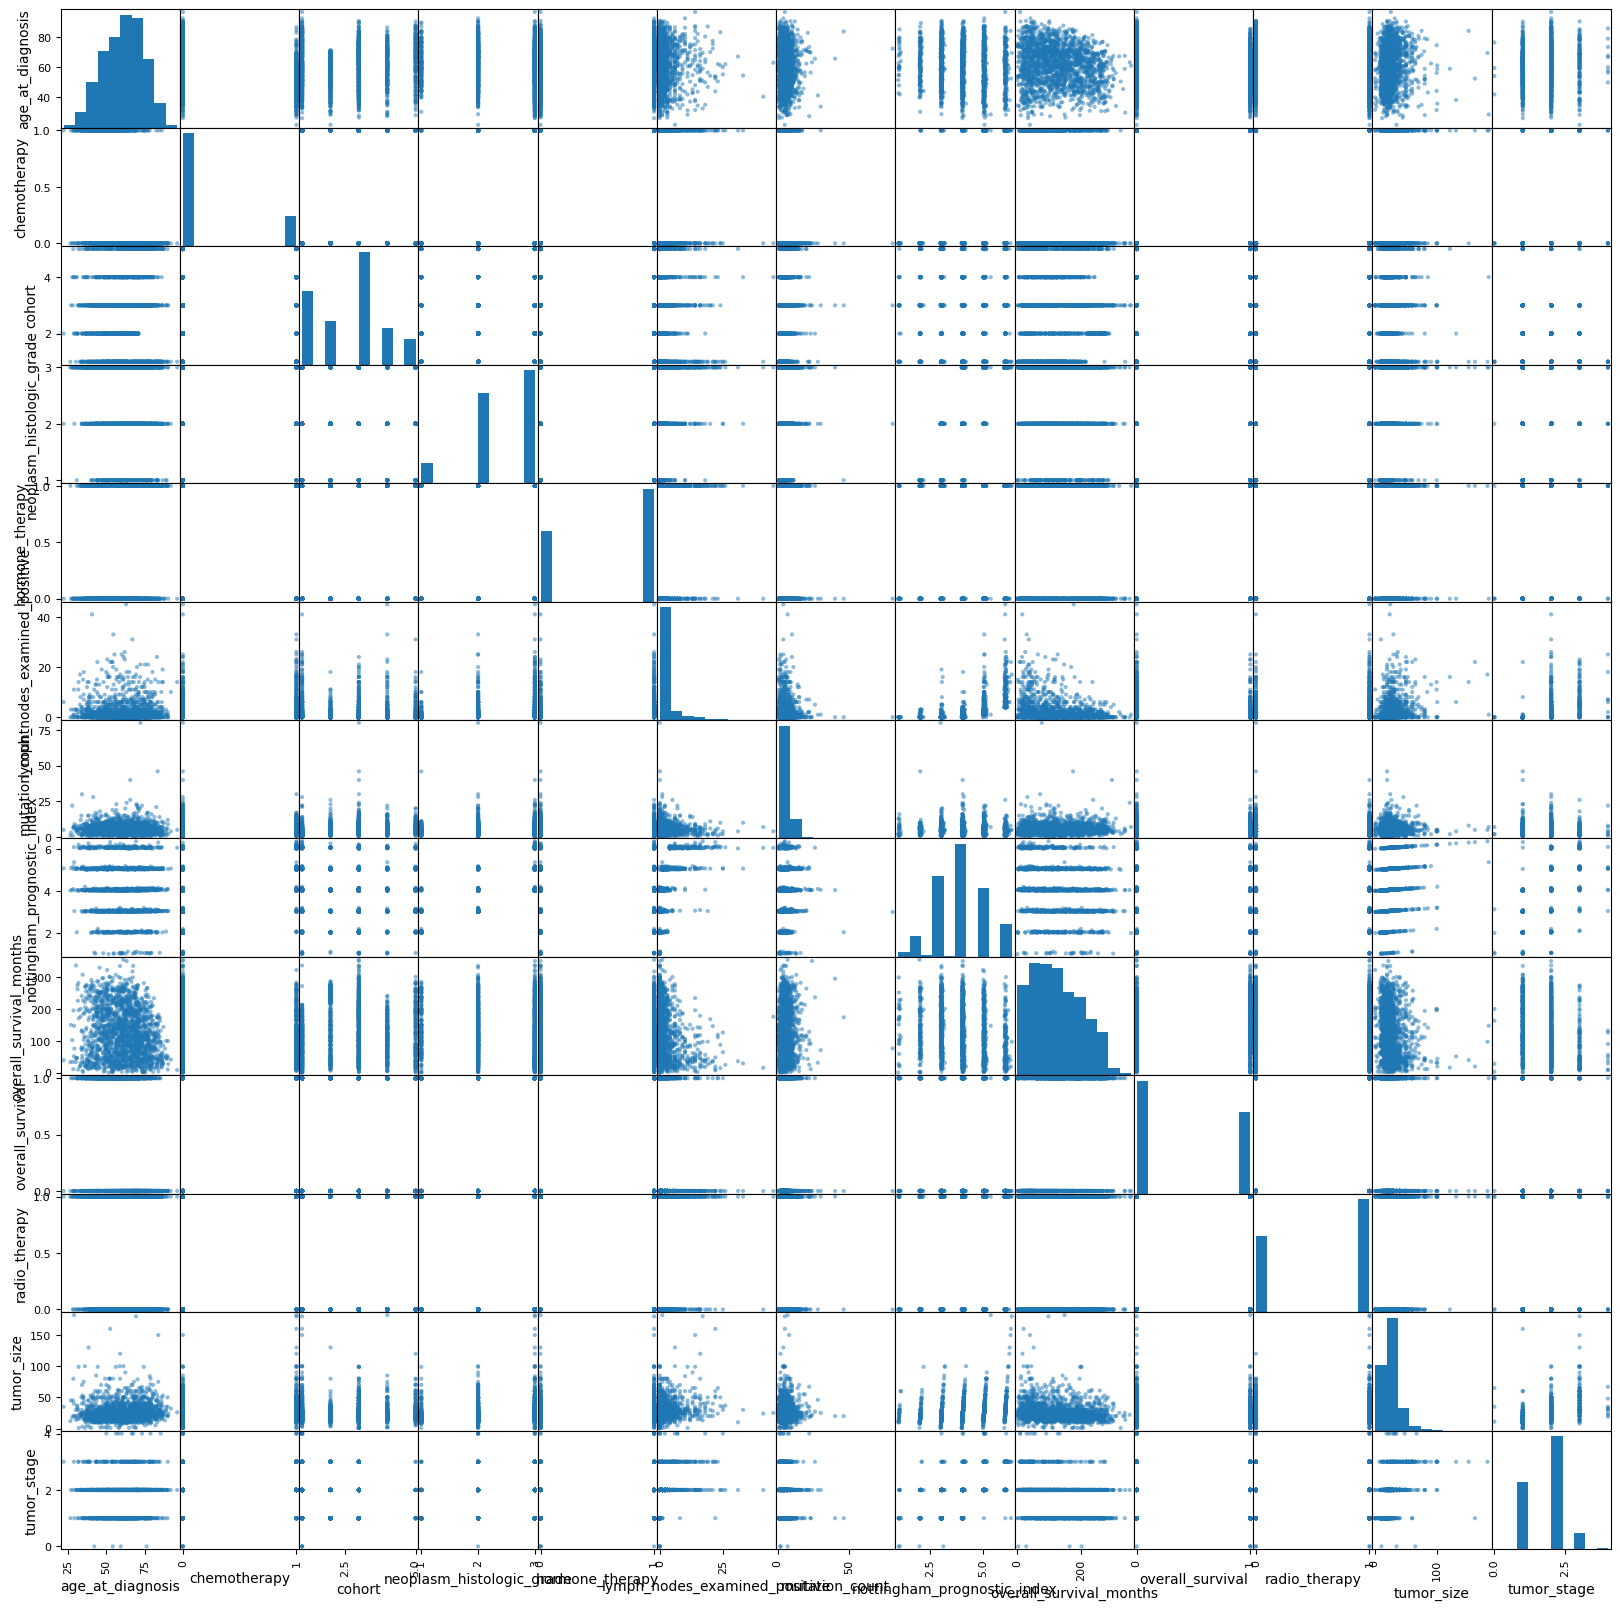

In [13]:
from pandas.plotting import scatter_matrix
scatter_matrix(cli_cols_num, figsize=(20, 20))
plt.show()

In [14]:
for col in cli_cols_cat.columns:
    print(cli_cols_cat[col].value_counts())

type_of_breast_surgery
MASTECTOMY           1127
BREAST CONSERVING     754
Name: count, dtype: int64
cancer_type_detailed
Breast Invasive Ductal Carcinoma             1500
Breast Mixed Ductal and Lobular Carcinoma     207
Breast Invasive Lobular Carcinoma             142
Breast Invasive Mixed Mucinous Carcinoma       22
Breast                                         17
Name: count, dtype: int64
cellularity
High        939
Moderate    710
Low         200
Name: count, dtype: int64
pam50_+_claudin-low_subtype
LumA           679
LumB           461
Her2           220
Basal          199
claudin-low    198
Normal         140
NC               6
Name: count, dtype: int64
er_status_measured_by_ihc
Positve     1445
Negative     428
Name: count, dtype: int64
er_status
Positive    1459
Negative     444
Name: count, dtype: int64
her2_status_measured_by_snp6
NEUTRAL    1382
GAIN        417
LOSS        100
UNDEF         4
Name: count, dtype: int64
her2_status
Negative    1667
Positive     236
Name: co

In [15]:
cli_cat_1hot_cols = ['pam50_+_claudin-low_subtype', 'her2_status_measured_by_snp6', 'tumor_other_histologic_subtype',
                    'integrative_cluster', '3-gene_classifier_subtype', "cancer_type_detailed"]
cli_cat_ord_cols = ['type_of_breast_surgery', 'cellularity', 'er_status_measured_by_ihc', 'er_status', 'her2_status',
                    'inferred_menopausal_state', 'primary_tumor_laterality', 'pr_status']

In [16]:
cli_cols_cat.columns

Index(['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'inferred_menopausal_state',
       'integrative_cluster', 'primary_tumor_laterality', 'pr_status',
       '3-gene_classifier_subtype'],
      dtype='object')

## RNA seq(gene expression profile)

In [17]:
RNA_seq_cols = breast_data.iloc[:, 28: 517]
RNA_seq_cols_names = RNA_seq_cols.columns

## RNA mutations

In [18]:
RNA_cols = breast_data.iloc[:, 517:]
RNA_cols.head()

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
patient_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,H178P,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,H1047R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,E542K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,S241F,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
RNA_cols_names = RNA_cols.columns
RNA_cols_names

Index(['pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut',
       'syne1_mut', 'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=173)

In [20]:
for col in RNA_cols_names:
    breast_data[col] = pd.to_numeric(RNA_cols[col], errors="coerce").fillna(1).astype(int)

## split data between target and features

In [21]:
Y = breast_data["death_from_cancer"]
X = breast_data.drop(columns=["death_from_cancer"])

## Import important functions for preprocessing

#### We need 4 pipelines:
1. pipeline for clinical categorical (1hot)
2. pipeline for clinical categorical (ordinal)
3. pipeline for clinical numerical
4. pipeline for the rest (mRNA seq cols) 

In [22]:
num_cli_pip = make_pipeline(SimpleImputer(strategy="median"),
                           StandardScaler(with_mean=False))

cli_cat_1hot_pip = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                OneHotEncoder(),
                                StandardScaler(with_mean=False))

cli_cat_ord_pip = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                OrdinalEncoder(),
                                StandardScaler(with_mean=False))



RNA_seq_pip = make_pipeline(SimpleImputer(strategy="median"))

In [23]:
preprocessing = ColumnTransformer([
    ("num1", num_cli_pip, cli_cols_num_names),
    ("num2", num_cli_pip, RNA_cols_names),
    ("cat_1hot", cli_cat_1hot_pip, cli_cat_1hot_cols),
    ("cat_ord", cli_cat_ord_pip, cli_cat_ord_cols)


], remainder="passthrough")

In [24]:
for_try = preprocessing.fit_transform(X)
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler(with_mean=False))]),
                                 Index(['age_at_diagnosis', 'chemotherapy', 'cohort',
       'neoplasm_histologic_grade', 'hormone_therapy',
       'lymph_nodes_examined_positive', 'mutation_count',
       'nottingham_prognosti...
                                  'cancer_type_detailed']),
                                ('cat_ord',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder()),
                                                 ('standardscaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['type_of_breast_surgery', 'cellularity',
                                  'er_status_measured_by_ihc', 'er_status',
                                  'her2_status', 'inferred_menopausal_state',
                                  'primary_tumor_laterality', 'pr_status'])])

In [25]:
preprocessing.named_transformers_

{'num1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler(with_mean=False))]),
 'num2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler(with_mean=False))]),
 'cat_1hot': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder', OneHotEncoder()),
                 ('standardscaler', StandardScaler(with_mean=False))]),
 'cat_ord': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder', OrdinalEncoder()),
                 ('standardscaler', StandardScaler(with_mean=False))]),
 'remainder': 'passthrough'}

In [26]:
new_cols_names = preprocessing.get_feature_names_out()

In [27]:
preprocessed_data = pd.DataFrame(for_try, columns=new_cols_names)

In [28]:
transformed_Y = pd.DataFrame(OrdinalEncoder().fit_transform(Y.values.reshape(-1, 1)), columns=["target"])

In [29]:
transformed_Y.target.value_counts()

target
2.0    801
0.0    622
1.0    479
Name: count, dtype: int64

In [30]:
Y.value_counts()

death_from_cancer
Living                  801
Died of Disease         622
Died of Other Causes    479
Name: count, dtype: int64

In [31]:
Y = Y.fillna("Living") 

In [32]:
LE = LabelEncoder()
Y_encoded = LE.fit_transform(Y)

In [33]:
Y_encoded

array([2, 2, 0, ..., 0, 1, 1])

In [34]:
set(list(Y_encoded))

{0, 1, 2}

In [35]:
np.where(Y_encoded == 3)

(array([], dtype=int64),)

In [36]:
Y_encoded[1165]

2

In [37]:
Y.iloc[1165]

'Living'

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42,
                                                   stratify=Y_encoded)

In [39]:
X_train_proc = preprocessing.fit_transform(X_train)
X_test_proc = preprocessing.transform(X_test)
n = pd.DataFrame(X_train_proc, columns=new_cols_names)

In [40]:
X_train_proc[200, 10]

0.0

## Data analysis

### The relationship between the type of cancer and the development of the disease

C:\Users\RobotComp.ru\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


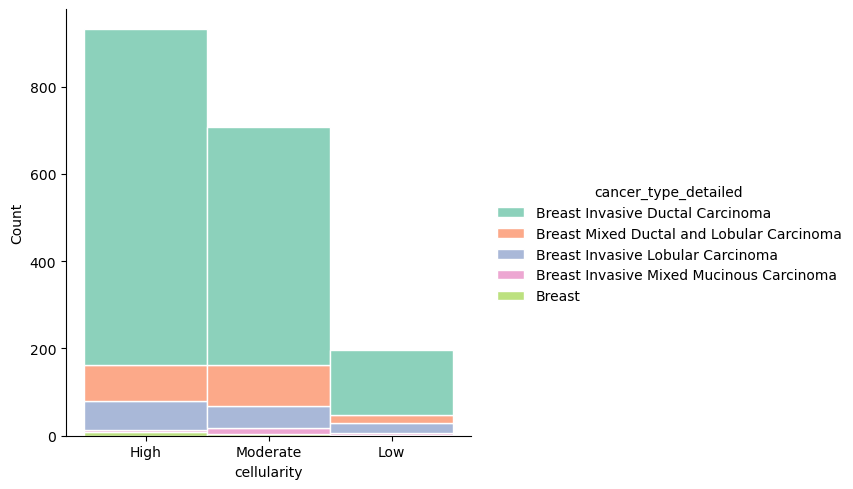

In [41]:
sns.displot(data=breast_data, x='cellularity', hue="cancer_type_detailed", multiple="stack",  palette=sns.color_palette("Set2")[0:5], edgecolor='white', linewidth=1)
plt.show()

### The relationship between cellular development of cancer and chemotherapy

C:\Users\RobotComp.ru\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


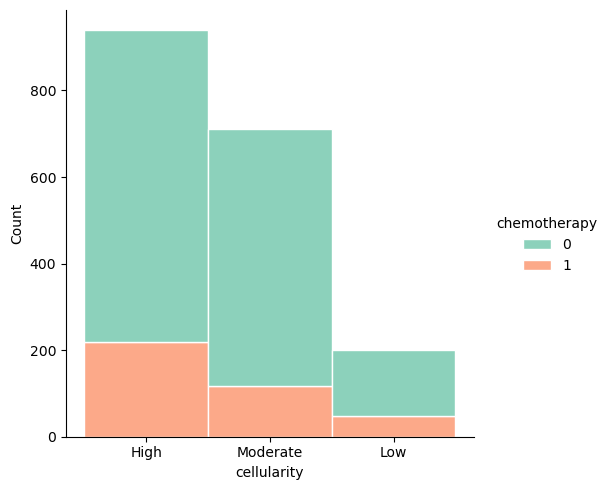

In [42]:
sns.displot(data=breast_data, x='cellularity', hue="chemotherapy", multiple="stack",  palette=sns.color_palette("Set2")[0:2], edgecolor='white', linewidth=1)
plt.show()

### The relationship between cellular development of cancer and radiotherapy

C:\Users\RobotComp.ru\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


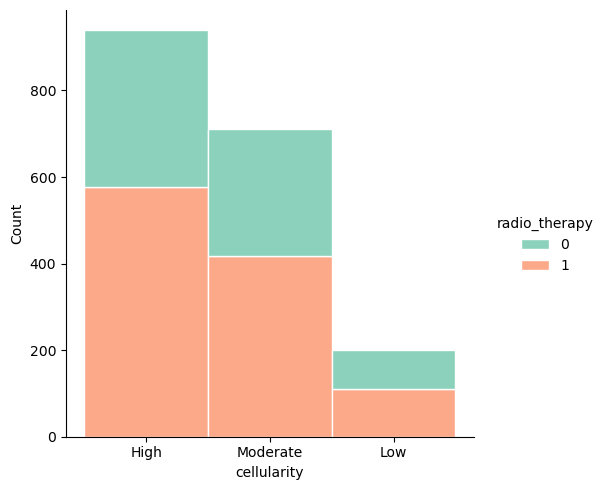

In [43]:
sns.displot(data=breast_data, x='cellularity', hue="radio_therapy", multiple="stack",  palette=sns.color_palette("Set2")[0:2], edgecolor='white', linewidth=1)
plt.show()

### Percentage of patients undergoing radiotherapy

([<matplotlib.patches.Wedge at 0x190654e5b50>,
 [Text(0.32988622036620957, 1.0493688968196537, '0'),
  Text(-0.32988612211720175, -1.049368927705826, '1')],
 [Text(0.17993793838156882, 0.5723830346289019, '40.3%'),
  Text(-0.17993788479120096, -0.572383051475905, '59.7%')])

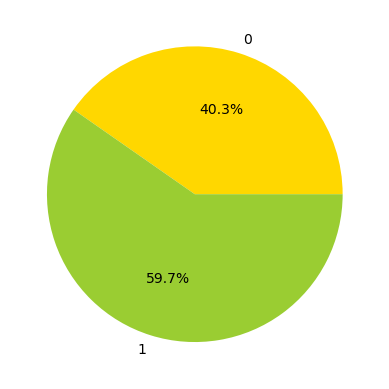

In [44]:
Radio_therapy =breast_data.groupby(['radio_therapy'])['age_at_diagnosis'].count()

labels = Radio_therapy.index
sizes = Radio_therapy.values
colors = ['gold', 'yellowgreen']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%')

### Percentage of patients undergoing chemotherapy

([<matplotlib.patches.Wedge at 0x1906631e450>,
 [Text(-0.873195049942625, 0.6689771332083756, '0'),
  Text(0.8731949873084617, -0.6689772149627936, '1')],
 [Text(-0.47628820905961355, 0.3648966181136594, '79.2%'),
  Text(0.47628817489552444, -0.3648966627069783, '20.8%')])

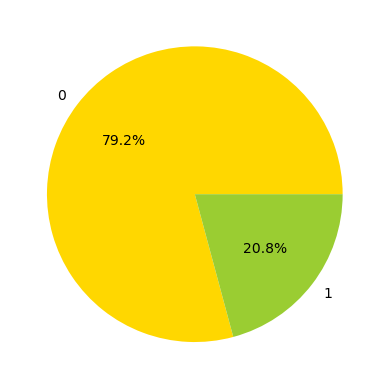

In [45]:
Chemotherapy =breast_data.groupby(['chemotherapy'])['age_at_diagnosis'].count()
labels = Chemotherapy.index
sizes = Chemotherapy.values
colors = ['gold', 'yellowgreen']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%')

### The relationship between cancer stage and tumor size

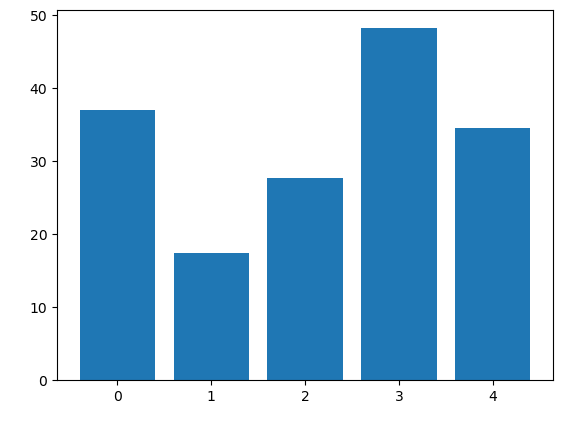

In [46]:
Tumor_stage =breast_data.groupby(['tumor_stage'])['tumor_size'].mean()
Tumor_stage.head()
x=Tumor_stage.index
y=Tumor_stage.values

plt.bar(x,y)
plt.xlabel("   ")
plt.ylabel(" ")
plt.show()

In [47]:
Tumor_stage.head()

tumor_stage
0.0    37.000000
1.0    17.400844
2.0    27.571875
3.0    48.230088
4.0    34.444444
Name: tumor_size, dtype: float64

### Survival rate in cancer patients

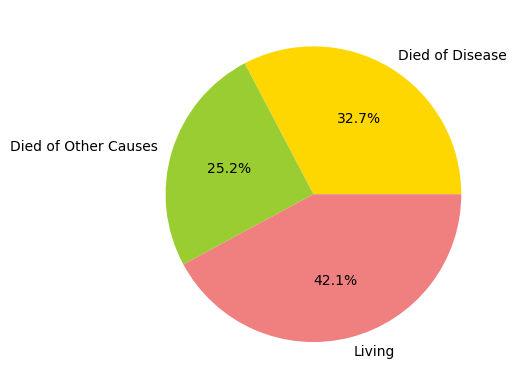

In [48]:
Death_from_cancer =breast_data.groupby(['death_from_cancer'])['age_at_diagnosis'].count()

labels = Death_from_cancer.index
sizes = Death_from_cancer.values
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%')
plt.show()

### Prevalence of tp53 mutation

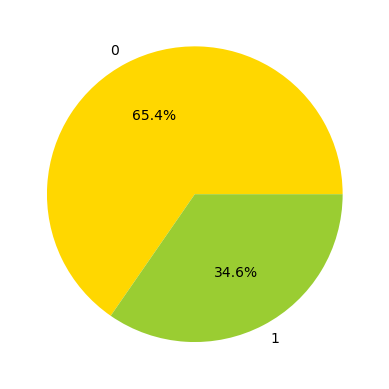

In [49]:
tp53_spend =breast_data.groupby(['tp53_mut'])['age_at_diagnosis'].count()
labels= tp53_spend.index
sizes= tp53_spend.values

colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%')
plt.show()

tumor_stage


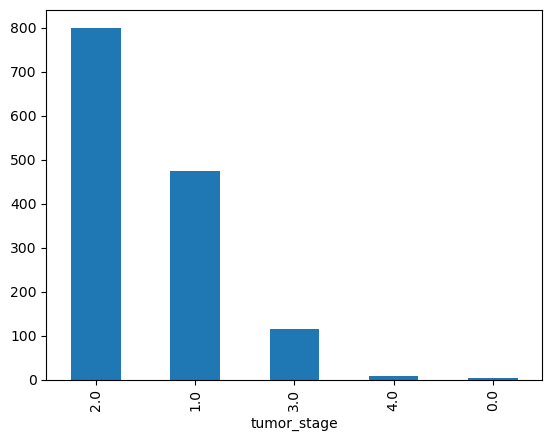

3-gene_classifier_subtype


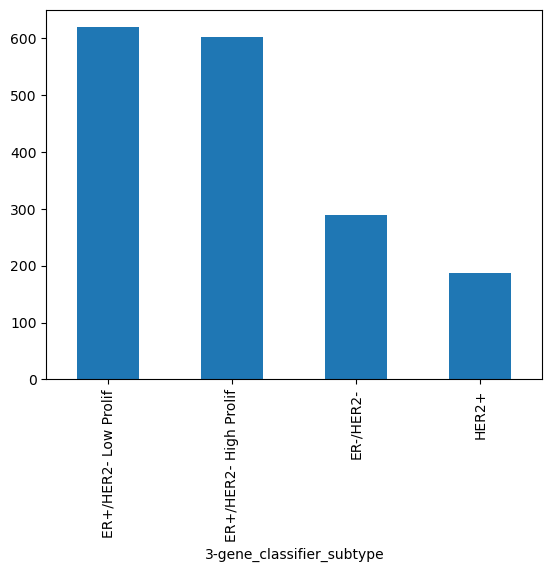

primary_tumor_laterality


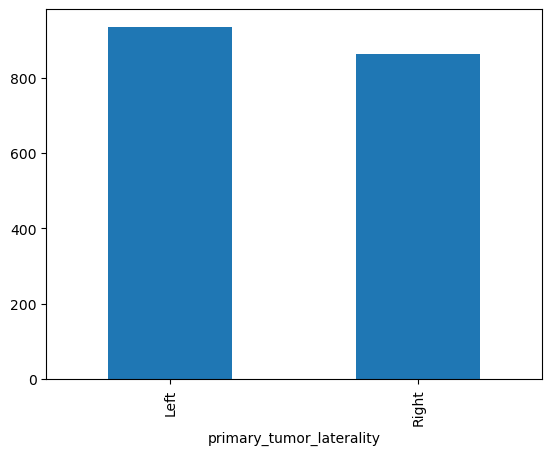

neoplasm_histologic_grade


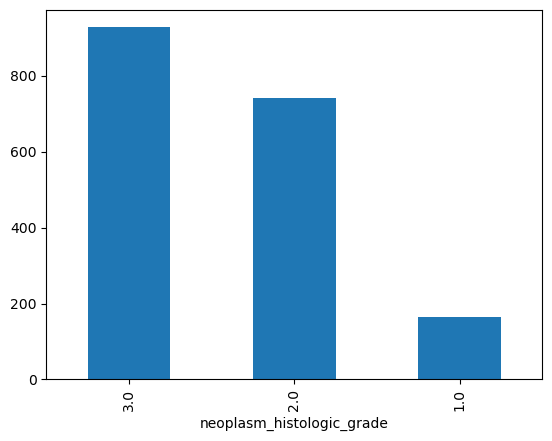

cellularity


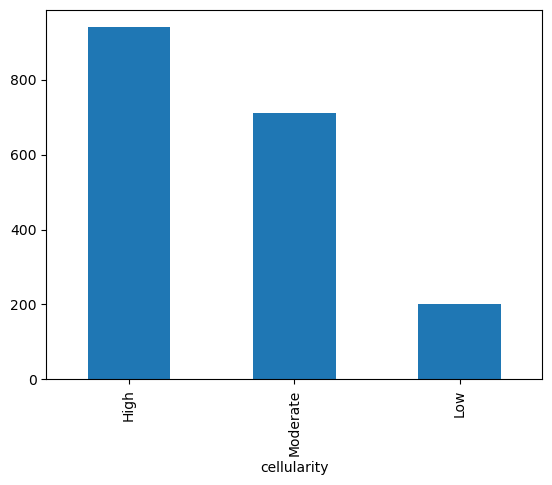

mutation_count


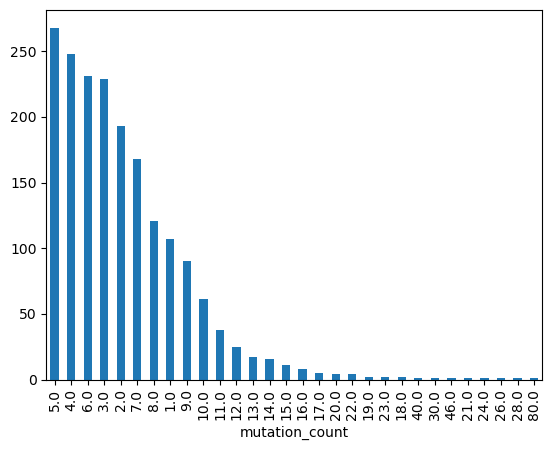

er_status_measured_by_ihc


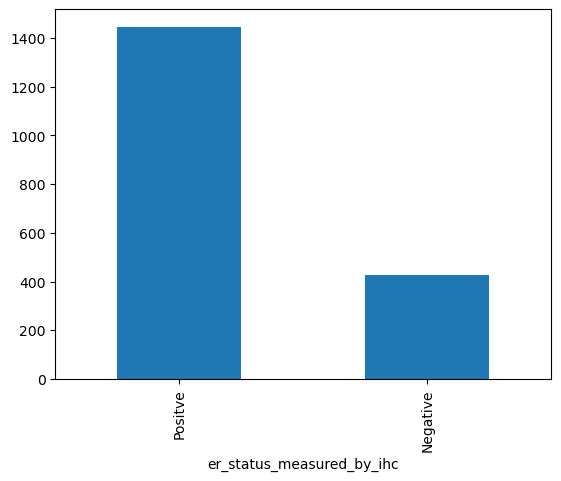

type_of_breast_surgery


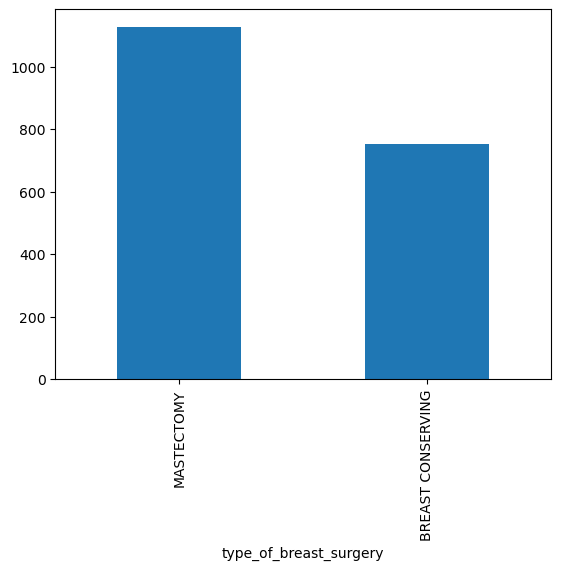

tumor_size


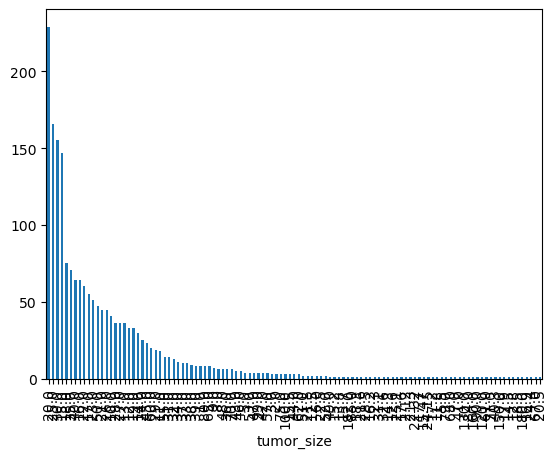

cancer_type_detailed


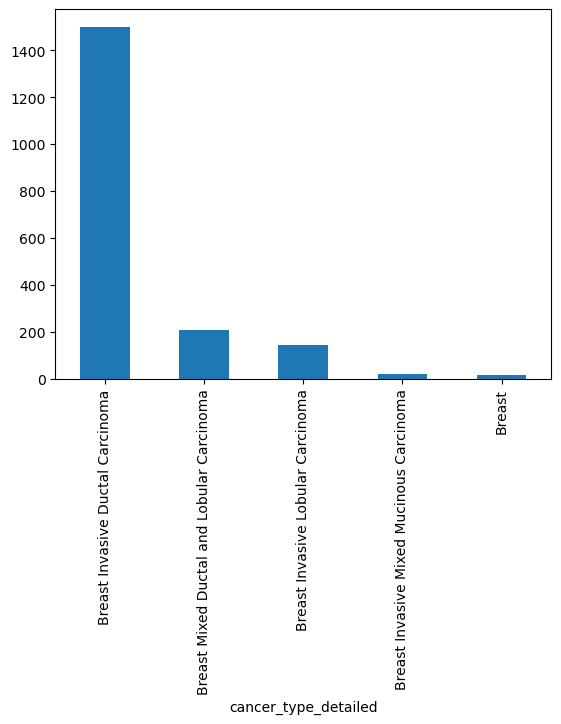

tumor_other_histologic_subtype


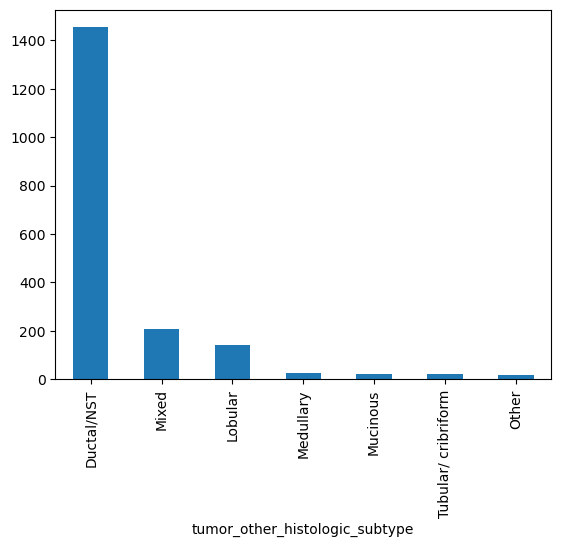

radio_therapy


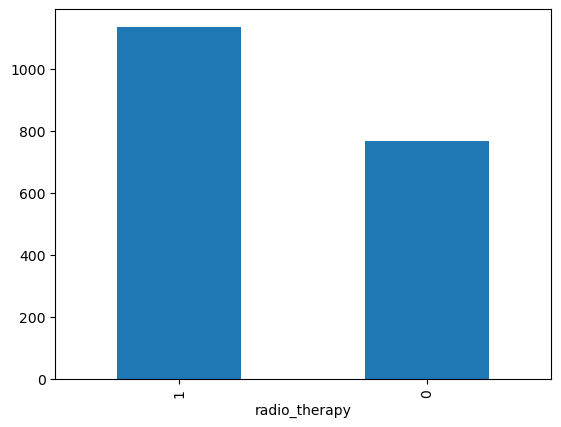

lymph_nodes_examined_positive


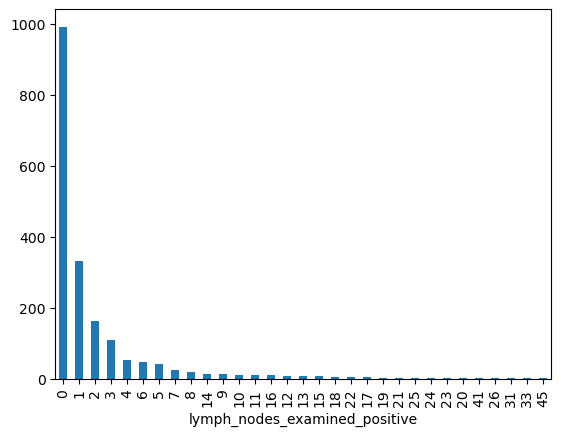

In [50]:
total = clinical_cols.isnull().sum().sort_values(ascending = False)
percent = (clinical_cols.isnull().sum() / clinical_cols.isnull().count()).sort_values(ascending=False)
missing_clinic = pd.concat([total, percent], axis = 1, keys = ['total_null', 'percent_null'])

for missing_column in missing_clinic.index[:13]:
    breast_data[missing_column].value_counts().plot.bar()
    print(missing_column)
    plt.show()

C:\Users\RobotComp.ru\anaconda3\Lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


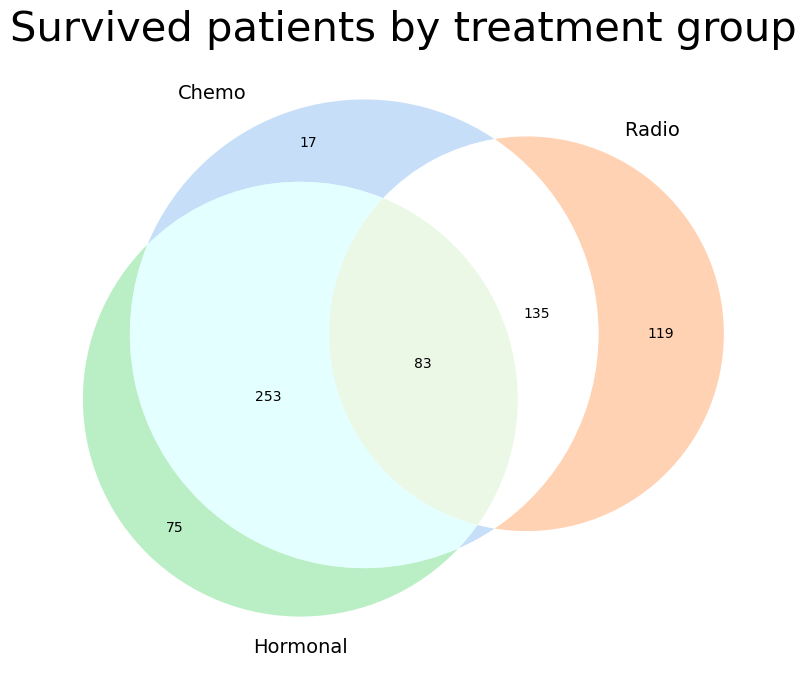

In [51]:
treatments = ['chemotherapy', 'hormone_therapy', 'radio_therapy']
died = breast_data[breast_data['overall_survival']==0]
survived = breast_data[breast_data['overall_survival']==1]

chemo = survived[(survived["chemotherapy"]==True) & (survived["radio_therapy"]==False) & (survived["hormone_therapy"]==False)]
radio = survived[(survived["chemotherapy"]==False) & (survived["radio_therapy"]==True) & (survived["hormone_therapy"]==False)]
hormonal = survived[(survived["chemotherapy"]==False) & (survived["radio_therapy"]==False) & (survived["hormone_therapy"]==True)]
chemo_radio = survived[(survived["chemotherapy"]==True) & (survived["radio_therapy"]==True) & (survived["hormone_therapy"]==False)]
radio_hormonal = survived[(survived["chemotherapy"]==False) & (survived["radio_therapy"]==True) & (survived["hormone_therapy"]==True)]
hormonal_chemo = survived[(survived["chemotherapy"]==True) & (survived["radio_therapy"]==False) & (survived["hormone_therapy"]==True)]
all_3 = survived[(survived["chemotherapy"]==True) & (survived["radio_therapy"]==True) & (survived["hormone_therapy"]==True)]

#calculate number of people for each combination and proportion death
df_subsets = [chemo, radio, hormonal, chemo_radio, radio_hormonal, hormonal_chemo, all_3]
sizes=[]
proportiondeath=[]
for dataframe in df_subsets:
    sizes.append(np.shape(dataframe)[0])
    proportiondeath.append(np.mean(dataframe["overall_survival"]))

#set size of circles relative to size of each subset (where possible)
#set gradient of blue according to proportion of death in subset calculated above
fig, ax = plt.subplots(figsize=(10,8))
v = venn3(subsets=sizes, set_labels=("Chemo", "Radio ", "Hormonal"), ax=ax, alpha=0.6, set_colors= sns.color_palette("pastel"))

for text in v.set_labels:
    text.set_fontsize(14)
    
ax.set_title("Survived patients by treatment group", size=30)
plt.show()

## ML Models

### 1. Random forest

In [52]:
n_estimators_list = [10, 100, 150, 200, 250, 300, 600]
for n_estimator in n_estimators_list:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
    rf_classifier.fit(X_train_proc, Y_train)
    y_pred = rf_classifier.predict(X_test_proc)
    accuracy = accuracy_score(Y_test, y_pred)
    print("for n_estimator = ", n_estimator," ", f'Accuracy: {accuracy:.2f}')

for n_estimator =  10   Accuracy: 0.68
for n_estimator =  100   Accuracy: 0.78
for n_estimator =  150   Accuracy: 0.80
for n_estimator =  200   Accuracy: 0.80
for n_estimator =  250   Accuracy: 0.80
for n_estimator =  300   Accuracy: 0.80
for n_estimator =  600   Accuracy: 0.81


In [53]:
y_pred = rf_classifier.predict(X_test_proc)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier, X_train_proc, Y_train, cv=kfold, scoring='accuracy')
cv_scores

Accuracy: 0.81


array([0.77377049, 0.78032787, 0.77631579, 0.78618421, 0.81907895])

In [54]:
rf_classifier = RandomForestClassifier(n_estimators=600, random_state=42)
rf_classifier.fit(X_train_proc, Y_train)
y_pred = rf_classifier.predict(X_test_proc)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       124
           1       0.71      0.57      0.63        96
           2       0.92      1.00      0.96       161

    accuracy                           0.81       381
   macro avg       0.78      0.77      0.77       381
weighted avg       0.80      0.81      0.80       381



### Support Vector Machine

In [55]:
svm_classifer = SVC(C=1, probability=True)
svm_classifer.fit(X_train_proc, Y_train)
Y_pr_tr = svm_classifer.predict(X_train_proc)
accuracy_score(Y_train, Y_pr_tr)

0.966491458607096

In [56]:
Y_pred = svm_classifer.predict(X_test_proc)
accuracy_score(Y_test, Y_pred)

0.7742782152230971

In [57]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       124
           1       0.71      0.57      0.63        96
           2       0.92      1.00      0.96       161

    accuracy                           0.81       381
   macro avg       0.78      0.77      0.77       381
weighted avg       0.80      0.81      0.80       381



### Adaboost


In [58]:
ada_clf=AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(max_depth=1),
    n_estimators=50, learning_rate=0.01,
    algorithm='SAMME.R'
)

In [59]:
ada_clf.fit(X_train_proc, Y_train)
y_pred=ada_clf.predict(X_test_proc)
accuracy= accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy: .2f}")
print(classification_report(Y_test, y_pred))

C:\Users\RobotComp.ru\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy:  0.81
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       124
           1       0.64      0.56      0.60        96
           2       1.00      1.00      1.00       161

    accuracy                           0.81       381
   macro avg       0.77      0.77      0.77       381
weighted avg       0.81      0.81      0.81       381



### Decision trees

In [60]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_proc, Y_train)
dt_pred=dt_classifier.predict(X_test_proc)
dt_accuracy=accuracy_score(Y_test,dt_pred)
print("Decision Tree Accuracy:", dt_accuracy)
print(classification_report(Y_test, dt_pred))

Decision Tree Accuracy: 0.7821522309711286
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       124
           1       0.56      0.60      0.58        96
           2       1.00      1.00      1.00       161

    accuracy                           0.78       381
   macro avg       0.75      0.75      0.75       381
weighted avg       0.78      0.78      0.78       381



### extra trees


In [61]:
et_classifier=ExtraTreesClassifier()
et_classifier.fit(X_train_proc, Y_train)
et_pred=et_classifier.predict(X_test_proc)
et_accuracy=accuracy_score(Y_test, et_pred)
print("Extra Tree Accuracy:", et_accuracy)
print(classification_report(Y_test, et_pred))

Extra Tree Accuracy: 0.821522309711286
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       124
           1       0.68      0.60      0.64        96
           2       0.98      1.00      0.99       161

    accuracy                           0.82       381
   macro avg       0.79      0.79      0.79       381
weighted avg       0.82      0.82      0.82       381



### xgboost

In [66]:
import xgboost as xgb

In [68]:
n_classes = 3
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=n_classes)
xgb_model.fit(X_train_proc, Y_train)
y_tr_pr = xgb_model.predict(X_train_proc)
print("Accuracy of xGBoost training is: ", accuracy_score(Y_train, y_tr_pr))

Accuracy of xGBoost training is:  1.0


In [69]:
y_pred = xgb_model.predict(X_test_proc)
print("xGBoost model accuracy is: ", accuracy_score(Y_test, y_pred), "\n")
print("xGBoost model classification report is as following:\n", classification_report(Y_test, et_pred))

xGBoost model accuracy is:  0.84251968503937 

xGBoost model classification report is as following:
               precision    recall  f1-score   support

           0       0.72      0.76      0.74       124
           1       0.68      0.60      0.64        96
           2       0.98      1.00      0.99       161

    accuracy                           0.82       381
   macro avg       0.79      0.79      0.79       381
weighted avg       0.82      0.82      0.82       381



### Neural networks

In [70]:
# nn_classifier = MLPClassifier(hidden_layer_sizes=(100, 50, 10, 3), max_iter=1000, activation='tanh', random_state=42)
nn_classifier = MLPClassifier(hidden_layer_sizes=(60, 20, 3), max_iter=1000, activation='relu', early_stopping=True, validation_fraction=0.1, n_iter_no_change=30, random_state=42)
nn_classifier.fit(X_train_proc, Y_train)
nn_pred=nn_classifier.predict(X_train_proc)
nn_accuracy=accuracy_score(Y_train, nn_pred)
nn_accuracy

0.9572930354796321

In [71]:
nn_pred = nn_classifier.predict(X_test_proc)
accuracy_score(Y_test, nn_pred)

0.6351706036745407

In [72]:
y_train = to_categorical(Y_train, num_classes=3)
y_test = to_categorical(Y_test, num_classes=3)

# Build the model
nn_model = Sequential([
    Dense(150, activation='relu', input_shape=(X_train_proc.shape[1],), kernel_regularizer=l1(0.002)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

C:\Users\RobotComp.ru\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

nn_model.fit(X_train_proc, y_train, epochs=50, batch_size=32, validation_split=0.1)

loss, accuracy = nn_model.evaluate(X_test_proc, y_test)
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4452 - loss: 9.8063 - val_accuracy: 0.5948 - val_loss: 7.8852
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7064 - loss: 7.2285 - val_accuracy: 0.6340 - val_loss: 6.2654
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8119 - loss: 5.6068 - val_accuracy: 0.7386 - val_loss: 4.9140
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8959 - loss: 4.2942 - val_accuracy: 0.8039 - val_loss: 3.7935
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9281 - loss: 3.2722 - val_accuracy: 0.8039 - val_loss: 2.9597
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9433 - loss: 2.4944 - val_accuracy: 0.8366 - val_loss: 2.2670
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9404 - loss: 1.8825 - val_accuracy: 0.8235 - val_loss: 1.7914
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9471 - loss: 1.4707 - val_accuracy: 0.8235 - val_loss:

### logistic regression (multiclass)


In [74]:

logistic_regression_classifier = LogisticRegression(max_iter=10000, random_state=42)
logistic_regression_classifier.fit(X_train_proc, Y_train)
y_pred_logreg = logistic_regression_classifier.predict(X_test_proc)
print("Logistic Regression")
print(f'Accuracy: {accuracy_score(Y_test, y_pred_logreg):.4f}')
print(classification_report(Y_test, y_pred_logreg))

Logistic Regression
Accuracy: 0.7507
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       124
           1       0.53      0.56      0.55        96
           2       0.99      0.96      0.97       161

    accuracy                           0.75       381
   macro avg       0.72      0.72      0.72       381
weighted avg       0.76      0.75      0.75       381



In [75]:
y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [76]:
label_binarize(y_test, classes=[0, 1, 2])

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [78]:
y_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

models = {
    'RandomForest': rf_classifier,
    'SVM': svm_classifer,
    'LogisticRegression': logistic_regression_classifier,
    'AdaBoost': ada_clf,
    'xGBoost' : xgb_model,
    'extra trees' : et_classifier,
    'decision trees' : dt_classifier,
    'neural nets' : nn_model
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


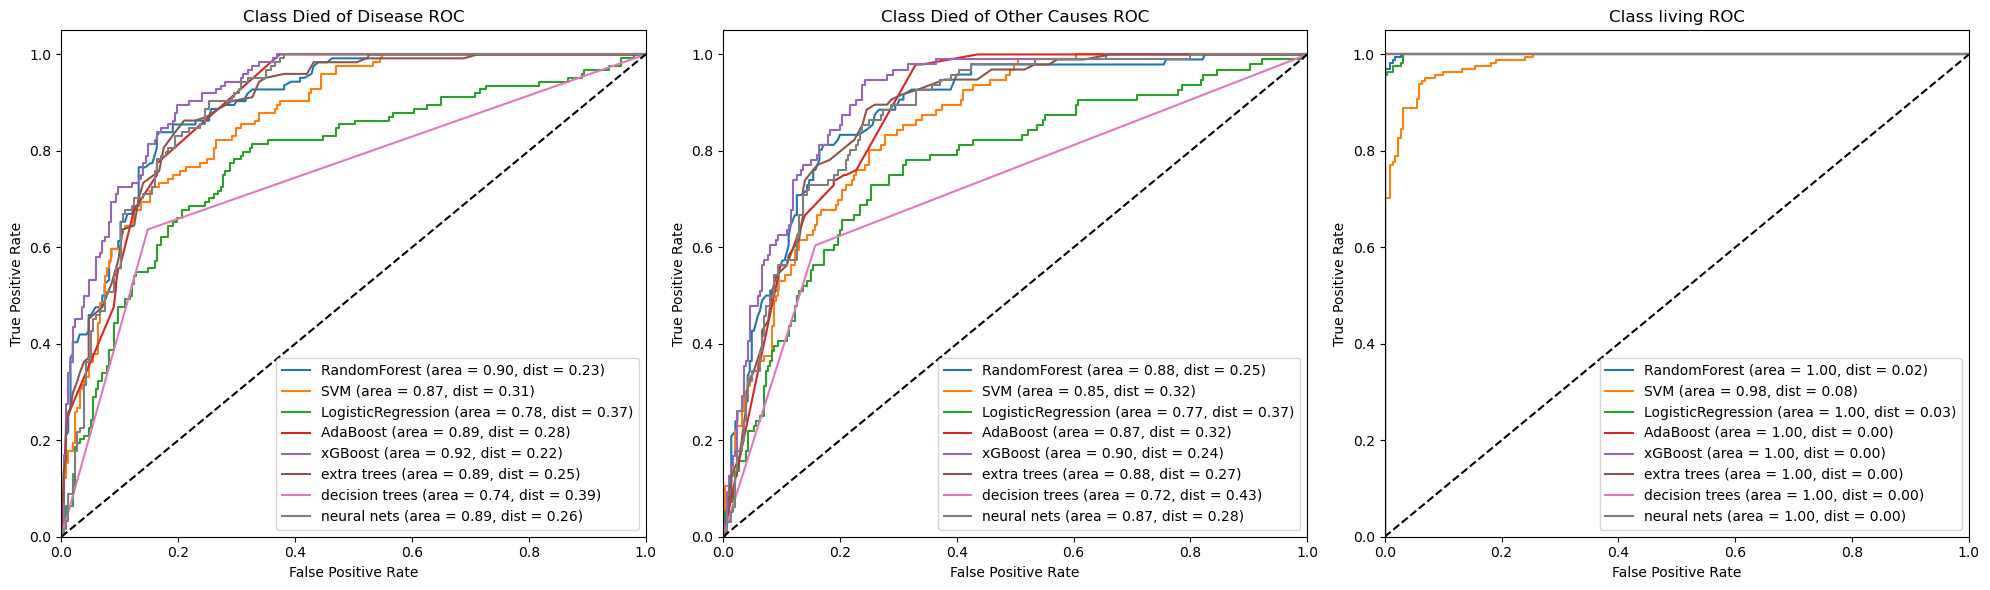

In [79]:
y_train_binarized = to_categorical(Y_train, num_classes=3)
y_test_binarized = to_categorical(Y_test, num_classes=3)

fpr = {0: {}, 1: {}, 2: {}}
tpr = {0: {}, 1: {}, 2: {}}
roc_auc = {0: {}, 1: {}, 2: {}}
distances = {0: {}, 1: {}, 2: {}}

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_proc)
    elif hasattr(model, "predict"):
        y_pred_proba = model.predict(X_test_proc)
    else:
        raise ValueError(f"Model {model_name} does not support predict_proba or predict methods.")
    
    for i in range(3):
        if hasattr(model, "predict_proba"):
            probs = y_pred_proba[:, i]
        else:
            probs = y_pred_proba[:, i]
        
        fpr[i][model_name], tpr[i][model_name], _ = roc_curve(y_test_binarized[:, i], probs)
        roc_auc[i][model_name] = auc(fpr[i][model_name], tpr[i][model_name])
        
        # Compute distance to the top-left corner
        distances[i][model_name] = np.sqrt((1 - tpr[i][model_name]) ** 2 + fpr[i][model_name] ** 2).min()

# Plot ROC Curves
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

###############################################################
cla = {0: "Died of Disease", 1: "Died of Other Causes", 2: "living"}
for i in range(3):
    ax = axs[i]
    for model_name in models.keys():
        ax.plot(fpr[i][model_name], tpr[i][model_name], label=f'{model_name} (area = {roc_auc[i][model_name]:.2f}, dist = {distances[i][model_name]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Class {cla[i]} ROC')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

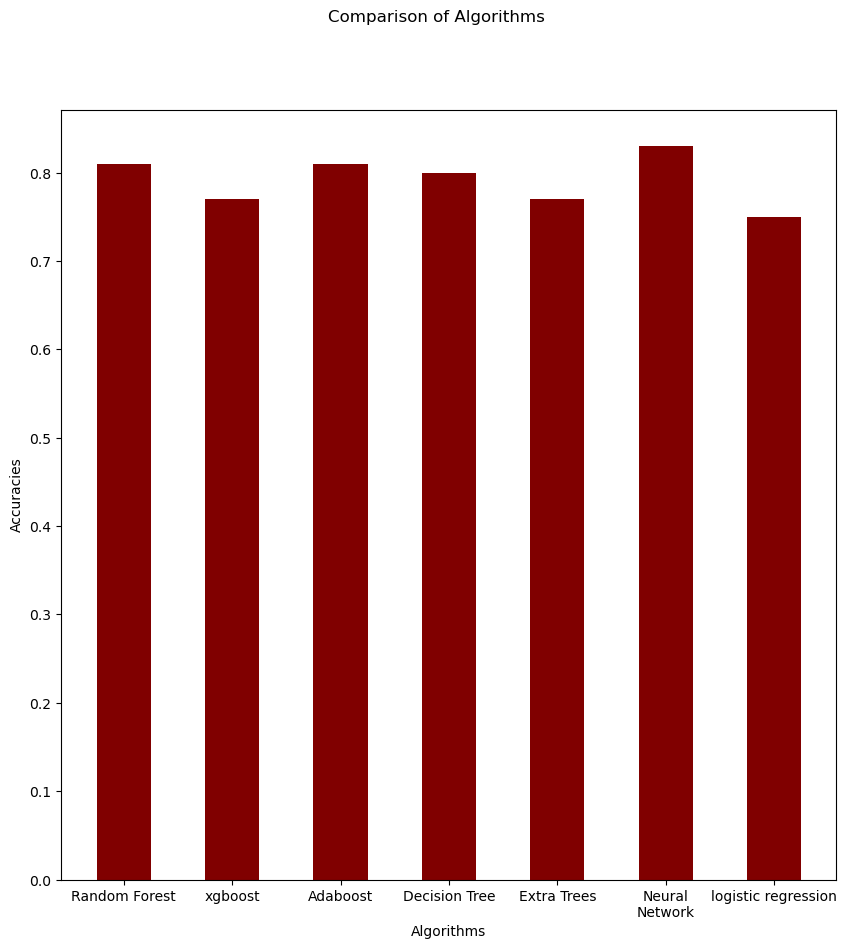

In [80]:
Algorithms =['Random Forest','xgboost','Adaboost','Decision Tree','Extra Trees','Neural\nNetwork','logistic regression']
fig = plt.figure(figsize =(10,10))
fig.suptitle('Comparison of Algorithms')
Accuracies =[0.81 , 0.77 , 0.81 , 0.80 , 0.77 , 0.83 , 0.75]
plt.bar(Algorithms, Accuracies, color ='maroon', width=0.5)
plt.xlabel('Algorithms')
plt.ylabel('Accuracies')
plt.show()

In [81]:
# importances = rf_classifier.feature_importances_
# indices = np.argsort(importances)[::-1]

# print("Feature ranking:")
# for f in range(X_train.shape[1]):
#     print(f"{f + 1}. Feature {indices[f]} (importance: {importances[indices[f]]:.4f})")

Feature ranking:
1. Feature 9 (importance: 0.1280)
2. Feature 8 (importance: 0.0316)
3. Feature 0 (importance: 0.0177)
4. Feature 7 (importance: 0.0071)
5. Feature 5 (importance: 0.0052)
6. Feature 352 (importance: 0.0040)
7. Feature 683 (importance: 0.0030)
8. Feature 279 (importance: 0.0029)
9. Feature 534 (importance: 0.0029)
10. Feature 284 (importance: 0.0029)
11. Feature 285 (importance: 0.0029)
12. Feature 11 (importance: 0.0028)
13. Feature 604 (importance: 0.0028)
14. Feature 258 (importance: 0.0028)
15. Feature 271 (importance: 0.0027)
16. Feature 401 (importance: 0.0027)
17. Feature 414 (importance: 0.0027)
18. Feature 229 (importance: 0.0026)
19. Feature 462 (importance: 0.0026)
20. Feature 669 (importance: 0.0026)
21. Feature 488 (importance: 0.0025)
22. Feature 564 (importance: 0.0025)
23. Feature 372 (importance: 0.0025)
24. Feature 552 (importance: 0.0024)
25. Feature 692 (importance: 0.0024)
26. Feature 442 (importance: 0.0024)
27. Feature 666 (importance: 0.0024)
28. 

In [82]:
preprocessing.get_feature_names_out()[450]

'remainder__mmp25'

In [83]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} (importance: {importances[indices[f]]:.4f})")


Feature ranking:
1. Feature 9 (importance: 0.1462)
2. Feature 374 (importance: 0.0125)
3. Feature 546 (importance: 0.0104)
4. Feature 8 (importance: 0.0104)
5. Feature 1 (importance: 0.0092)
6. Feature 105 (importance: 0.0089)
7. Feature 121 (importance: 0.0086)
8. Feature 560 (importance: 0.0079)
9. Feature 512 (importance: 0.0078)
10. Feature 620 (importance: 0.0077)
11. Feature 628 (importance: 0.0077)
12. Feature 419 (importance: 0.0074)
13. Feature 397 (importance: 0.0072)
14. Feature 0 (importance: 0.0071)
15. Feature 597 (importance: 0.0071)
16. Feature 440 (importance: 0.0069)
17. Feature 420 (importance: 0.0069)
18. Feature 426 (importance: 0.0068)
19. Feature 243 (importance: 0.0065)
20. Feature 554 (importance: 0.0063)
21. Feature 393 (importance: 0.0060)
22. Feature 37 (importance: 0.0060)
23. Feature 228 (importance: 0.0059)
24. Feature 382 (importance: 0.0058)
25. Feature 479 (importance: 0.0057)
26. Feature 624 (importance: 0.0056)
27. Feature 508 (importance: 0.0054)
28

In [84]:
importances = np.abs(logistic_regression_classifier.coef_[0])
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} (importance: {importances[indices[f]]:.4f})")

Feature ranking:
1. Feature 9 (importance: 1.8449)
2. Feature 8 (importance: 1.4607)
3. Feature 450 (importance: 0.5605)
4. Feature 0 (importance: 0.4793)
5. Feature 353 (importance: 0.4694)
6. Feature 315 (importance: 0.4478)
7. Feature 472 (importance: 0.4474)
8. Feature 77 (importance: 0.4386)
9. Feature 229 (importance: 0.4299)
10. Feature 546 (importance: 0.4258)
11. Feature 384 (importance: 0.4176)
12. Feature 718 (importance: 0.4129)
13. Feature 575 (importance: 0.4011)
14. Feature 493 (importance: 0.3957)
15. Feature 131 (importance: 0.3788)
16. Feature 716 (importance: 0.3774)
17. Feature 453 (importance: 0.3760)
18. Feature 553 (importance: 0.3753)
19. Feature 692 (importance: 0.3747)
20. Feature 414 (importance: 0.3660)
21. Feature 377 (importance: 0.3621)
22. Feature 566 (importance: 0.3605)
23. Feature 640 (importance: 0.3604)
24. Feature 695 (importance: 0.3601)
25. Feature 217 (importance: 0.3583)
26. Feature 206 (importance: 0.3545)
27. Feature 54 (importance: 0.3527)
2